# Machine Learning with ICESat-2 data

A machine learning pipeline from point clouds to photon classifications.

Reimplementation of [Koo et al., 2023](https://doi.org/10.1016/j.rse.2023.113726),
based on code available at https://github.com/YoungHyunKoo/IS2_ML.

```{admonition} Learning Objectives
By the end of this tutorial, you should be able to:
- Convert ICESat-2 point cloud data into an analysis/ML-ready format
- Recognize the different levels of complexity of ML approaches and the
  benefits/challenges of each
- Learn the potential of using ML for ICESat-2 photon classification
```

![ICESat-2 ATL07 sea ice photon classification ML pipeline](https://github.com/user-attachments/assets/509dab2d-d25d-417f-97ff-fc966f656ddf)

## Part 0: Setup

Let's start by importing all the libraries needed for data access, processing and
visualization later. If you're running this on CryoCloud's default image without
Pytorch installed, uncomment and run the first cell before continuing.

In [1]:
# !mamba install -y pytorch

In [2]:
import earthaccess
import geopandas as gpd
import h5py
import numpy as np
import pandas as pd
import pygmt
import pystac_client
import rioxarray  # noqa: F401
import shapely.geometry
import stackstac
import torch
import tqdm

## Part 1: Convert ICESat-2 data into ML-ready format

Steps:
- Get ATL07 data using [earthaccess](https://earthaccess.readthedocs.io)
- Find coincident Sentinel-2 imagery by searching over a
  [STAC API](https://pystac-client.readthedocs.io/en/v0.8.3/usage.html#itemsearch)
- Filter to only strong beams, and 6 key data variables + ancillary variables

### Search for ATL07 data over study area

In this sub-section, we'll set up a spatiotemporal query to look for ICESat-2 ATL07
sea ice data over the Ross Sea region around late October 2019.

Ref: https://earthaccess.readthedocs.io/en/latest/quick-start/#get-data-in-3-steps

In [3]:
# Authenticate using NASA EarthData login
auth = earthaccess.login()
# s3 = earthaccess.get_s3fs_session(daac="NSIDC")  # Start an AWS S3 session

Enter your Earthdata Login username:  weiji14
Enter your Earthdata password:  ········


In [4]:
# Set up spatiotemporal query for ATL07 sea ice product
granules = earthaccess.search_data(
    short_name="ATL07",
    cloud_hosted=True,
    bounding_box=(-180, -78, -140, -70),  # xmin, ymin, xmax, ymax
    temporal=("2019-10-31", "2019-11-01"),
    version="006",
)
granules[-1]  # visualize last data granule

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Height V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': 40.10013383465392, 'StartLatitude': -27.0, 'StartDirection': 'D', 'EndLatitude': -27.0, 'EndDirection': 'A'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-11-01T19:39:35.790Z', 'EndingDateTime': '2019-11-01T19:54:06.084Z'}}
Size(MB): 42.600958824157715
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2019/11/01/ATL07-02_20191101183543_05480501_006_01.h5']

#### Find coincident Sentinel-2 imagery

Let's also find some optical satellite images that were captured at around the same
time and location as the ICESat-2 ATL07 tracks. We will be using
[`pystac_client.Client.search`](https://pystac-client.readthedocs.io/en/v0.8.3/api.html#pystac_client.Client.search)
and doing the search with two steps:

1. (Fast) search using date to find potential Sentinel-2/ICESat-2 pairs
2. (Slow) search using spatial intersection to ensure Sentinel-2 image overlaps with
   ICESat-2 track.

In [5]:
# Connect to STAC API that hosts Sentinel-2 imagery on AWS us-west-2
catalog = pystac_client.Client.open(url="https://earth-search.aws.element84.com/v1")

In [6]:
# Loop over each ATL07 data granule, and find Sentinel-2 images from same time range
for granule in tqdm.tqdm(iterable=granules):
    # Get ATL07 time range from Unified Metadata Model (UMM)
    date_range = granule["umm"]["TemporalExtent"]["RangeDateTime"]
    start_time = date_range["BeginningDateTime"]  # e.g. '2019-02-24T19:51:47.580Z'
    end_time = date_range["EndingDateTime"]  # e.g. '2019-02-24T19:52:08.298Z'

    # 1st check (temporal match)
    search1 = catalog.search(
        collections="sentinel-2-l2a",  # Bottom-of-Atmosphere product
        bbox=[-180, -78, -140, -70],  # xmin, ymin, xmax, ymax
        datetime=f"{start_time}/{end_time}",
        query={"eo:cloud_cover": {"lt": 30}},  # max cloud cover
        max_items=10,
    )
    _item_collection = search1.item_collection()
    if (_item_len := len(_item_collection)) >= 1:
        # print(f"Potential: {_item_len} Sentinel-2 x ATL07 matches!")

        # 2nd check (spatial match) using centre-line track intersection
        file_obj = earthaccess.open(granules=[granule])[0]
        atl_file = h5py.File(name=file_obj, mode="r")
        linetrack = shapely.geometry.LineString(
            coordinates=zip(
                atl_file["gt2r/sea_ice_segments/longitude"][:10000],
                atl_file["gt2r/sea_ice_segments/latitude"][:10000],
            )
        ).simplify(tolerance=10)
        search2 = catalog.search(
            collections="sentinel-2-l2a",
            intersects=linetrack,
            datetime=f"{start_time}/{end_time}",
            max_items=10,
        )
        item_collection = search2.item_collection()
        if (item_len := len(item_collection)) >= 1:
            print(
                f"Found: {item_len} Sentinel-2 items coincident with granule:\n{granule}"
            )
            break  # uncomment this line if you want to find more matches

 25%|██▌       | 2/8 [00:00<00:00, 12.12it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:03<00:05,  1.12s/it]

Found: 4 Sentinel-2 items coincident with granule:
Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Height V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': 34.39032297860235, 'StartLatitude': -27.0, 'StartDirection': 'D', 'EndLatitude': -27.0, 'EndDirection': 'A'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-10-31T20:05:15.872Z', 'EndingDateTime': '2019-10-31T20:20:05.522Z'}}
Size(MB): 57.1460075378418
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2019/10/31/ATL07-02_20191031190122_05330501_006_01.h5']


We should have found a match! In case you missed it, these are the two variables
pointing to the data we'll use later:

- `granule` - ICESat-2 ATL07 sea ice point cloud data
- `item_collection` - Sentinel-2 optical satellite images

### Filter to strong beams and required data variables

Here, we'll open one ATL07 sea ice data file, and do some pre-processing.

In [7]:
%%time
file_obj = earthaccess.open(granules=[granule])[0]
atl_file = h5py.File(name=file_obj, mode="r")
atl_file.keys()

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 51.8 ms, sys: 7.77 ms, total: 59.5 ms
Wall time: 148 ms


<KeysViewHDF5 ['METADATA', 'ancillary_data', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r', 'orbit_info', 'quality_assessment']>

Strong beams can be chosen based on the `sc_orient` variable.

Ref: https://github.com/ICESAT-2HackWeek/strong-beams

In [8]:
# orientation - 0: backward, 1: forward, 2: transition
orient = atl_file["orbit_info"]["sc_orient"][:]
if orient == 0:
    strong_beams = ["gt1l", "gt2l", "gt3l"]
elif orient == 1:
    strong_beams = ["gt3r", "gt2r", "gt1r"]
strong_beams

['gt3r', 'gt2r', 'gt1r']

To keep things simple, we'll only read one beam today, but feel free to get all three
using a for-loop in your own project.

In [9]:
for beam in strong_beams:
    print(beam)

gt3r
gt2r
gt1r


Key data variables to use (for model training):
  1. `photon_rate`: photon rate
  2. `hist_w`: width of the photon height distribution
  3. `background_r_norm`: background photon rate
  4. `height_segment_height`: relative surface height
  5. `height_segment_n_pulse_seg`: number of laser pulses
  6. `hist_mean_median_h_diff` = `hist_mean_h` - `hist_median_h`: difference between
      mean and median height

Other data variables:
- `x_atc` - Along track distance from the equator
- `layer_flag` - Consolidated cloud flag { 0: 'likely_clear', 1: 'likely_cloudy' }
- `height_segment_ssh_flag` - Sea surface flag { 0: 'sea ice', 1: 'sea surface' }

Data dictionary at:
https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl07_data_dict_v006.pdf

In [10]:
gdf = gpd.GeoDataFrame(
    data={
        # Key data variables
        "photon_rate": atl_file[f"{beam}/sea_ice_segments/stats/photon_rate"][:],
        "hist_w": atl_file[f"{beam}/sea_ice_segments/stats/hist_w"][:],
        "background_r_norm": atl_file[
            f"{beam}/sea_ice_segments/stats/background_r_norm"
        ][:],
        "height_segment_height": atl_file[
            f"{beam}/sea_ice_segments/heights/height_segment_height"
        ][:],
        "height_segment_n_pulse_seg": atl_file[
            f"{beam}/sea_ice_segments/heights/height_segment_n_pulse_seg"
        ][:],
        "hist_mean_h": atl_file[f"{beam}/sea_ice_segments/stats/hist_mean_h"][:],
        "hist_median_h": atl_file[f"{beam}/sea_ice_segments/stats/hist_median_h"][:],
        # Other data variables
        "x_atc": atl_file[f"{beam}/sea_ice_segments/seg_dist_x"][:],
        "layer_flag": atl_file[f"{beam}/sea_ice_segments/stats/layer_flag"][:],
        "height_segment_ssh_flag": atl_file[
            f"{beam}/sea_ice_segments/heights/height_segment_ssh_flag"
        ][:],
    },
    geometry=gpd.points_from_xy(
        x=atl_file[f"{beam}/sea_ice_segments/longitude"][:],
        y=atl_file[f"{beam}/sea_ice_segments/latitude"][:],
    ),
    crs="OGC:CRS84",
)

In [11]:
# Pre-processing data
gdf = gdf[gdf.layer_flag == 0].reset_index(drop=True)  # keep non-cloudy points only
gdf["hist_mean_median_h_diff"] = gdf.hist_mean_h - gdf.hist_median_h
print(f"Total number of rows: {len(gdf)}")

Total number of rows: 38246


In [12]:
gdf

photon_rate    hist_w  background_r_norm  height_segment_height  \
0         3.512820  0.128929        3470228.250               0.085903   
1         4.181818  0.159623        3462216.000               0.117592   
2         4.156250  0.189304        3460210.250               0.170189   
3         4.551724  0.272234        3457500.000               0.236546   
4         4.620690  0.224559        3411361.250               0.252434   
...            ...       ...                ...                    ...   
38241     7.722222  0.146530        1436920.250               0.075413   
38242     7.944445  0.142120        1436920.250               0.048256   
38243     7.578948  0.140504        1436920.250               0.033785   
38244     6.714286  0.139510        1428857.875               0.026987   
38245     6.857143  0.135262        1397495.875               0.009361   

       height_segment_n_pulse_seg  hist_mean_h  hist_median_h         x_atc  \
0                              38   -53.941635     -53.943508  2.744329e+07   
1                              32   -53.906929     -53.901737  2.744330e+07   
2                              31   -53.872688     -53.853218  2.744331e+07   
3                              28   -53.877270     -53.831566  2.744332e+07   
4                              28   -53.828976     -53.795189  2.744333e+07   
...                           ...          ...            ...           ...   
38241                          17    18.942928      18.955540  3.303276e+07   
38242                          17    18.921795      18.934738  3.303276e+07   
38243                          18    18.893675      18.913025  3.303277e+07   
38244                          20    18.867090      18.901897  3.303278e+07   
38245                          20    18.852695      18.881191  3.303279e+07   

       layer_flag  height_segment_ssh_flag                      geometry  \
0               0                        0   POINT (-166.17149 -66.1212)   
1               0                        0  POINT (-166.17152 -66.12129)   
2               0                        0  POINT (-166.17154 -66.12139)   
3               0                        0  POINT (-166.17156 -66.12148)   
4               0                        0  POINT (-166.17159 -66.12156)   
...           ...                      ...                           ...   
38241           0                        0    POINT (18.94094 -63.78423)   
38242           0                        0    POINT (18.94093 -63.78418)   
38243           0                        0    POINT (18.94092 -63.78413)   
38244           0                        0     POINT (18.9409 -63.78406)   
38245           0                        0      POINT (18.94089 -63.784)   

       hist_mean_median_h_diff  
0                     0.001873  
1                    -0.005192  
2                    -0.019470  
3                    -0.045704  
4                    -0.033787  
...                        ...  
38241                -0.012611  
38242                -0.012943  
38243                -0.019350  
38244                -0.034807  
38245                -0.028496  

[38246 rows x 12 columns]

### Optical imagery to label point clouds

Let's use the Sentinel-2 satellite image we found to label each ATL07 photon. We'll
make a new column called `sea_ice_label` that can have either of these classifications:

0. thick/snow-covered sea ice
1. thin/gray sea ice
2. open water

These labels will be empirically determined based on the brightness (or surface
reflectance) of the Sentinel-2 pixel.

```{note}
Sea ice can move very quickly in minutes, so while we've tried our best to find a
Sentinel-2 image that was captured at about the same time as the ICESat-2 track, it is
very likely that we will still be misclassifying some of the points below because the
image and point clouds are not perfectly aligned.
```

In [13]:
# Get first STAC item from collection
item = item_collection.items[0]
item

<Item id=S2B_2CND_20191031_0_L2A>

Use [`stackstac.stack`](https://stackstac.readthedocs.io/en/v0.5.1/api/main/stackstac.stack.html)
to get the RGB bands from the Sentinel-2 image.

In [14]:
# Get RGB bands from Sentinel-2 STAC item as an xarray.DataArray
da_image = stackstac.stack(
    items=item,
    assets=["red", "green", "blue"],
    resolution=60,
    rescale=False,  # keep original 14-bit scale
    dtype=np.float32,
    fill_value=np.float32(np.nan),
)
da_image = da_image.squeeze(dim="time")  # drop time dimension so only (band, y, x) left
da_image

<xarray.DataArray 'stackstac-bd9892c19b6c86ec2d80ee484fd3c349' (band: 3,
                                                                y: 1831, x: 1830)> Size: 40MB
dask.array<getitem, shape=(3, 1831, 1830), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/54)
    time                                     datetime64[ns] 8B 2019-10-31T20:...
    id                                       <U23 92B 'S2B_2CND_20191031_0_L2A'
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 15kB 5e+05 ... 6.097...
  * y                                        (y) float64 15kB 1.9e+06 ... 1.7...
    s2:sequence                              <U1 4B '0'
    ...                                       ...
    title                                    (band) <U20 240B 'Red (band 4) -...
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32702
Attributes:
    spec:        RasterSpec(epsg=32702, bounds=(499980, 1790160, 609780, 1900...
    crs:         epsg:32702
    transform:   | 60.00, 0.00, 499980.00|\n| 0.00,-60.00, 1900020.00|\n| 0.0...
    resolution:  60

In [15]:
# Get bounding box of Sentinel-2 image to spatially subset ATL07 geodataframe
bbox = shapely.geometry.box(*da_image.rio.bounds())  # xmin, ymin, xmax, ymax
gdf = gdf.to_crs(crs=da_image.crs)  # reproject point cloud to Sentinel-2 image's CRS
gdf = gdf[gdf.within(other=bbox)].reset_index()  # subset point cloud to Sentinel-2 bbox

Let's plot the Sentinel-2 satellite image and ATL07 points! The ATL07 data has a
`height_segment_ssh_flag` variable with a binary sea ice (0) / sea surface (1)
classification, which we'll plot using two different colors to check that things
overlap more or less.

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


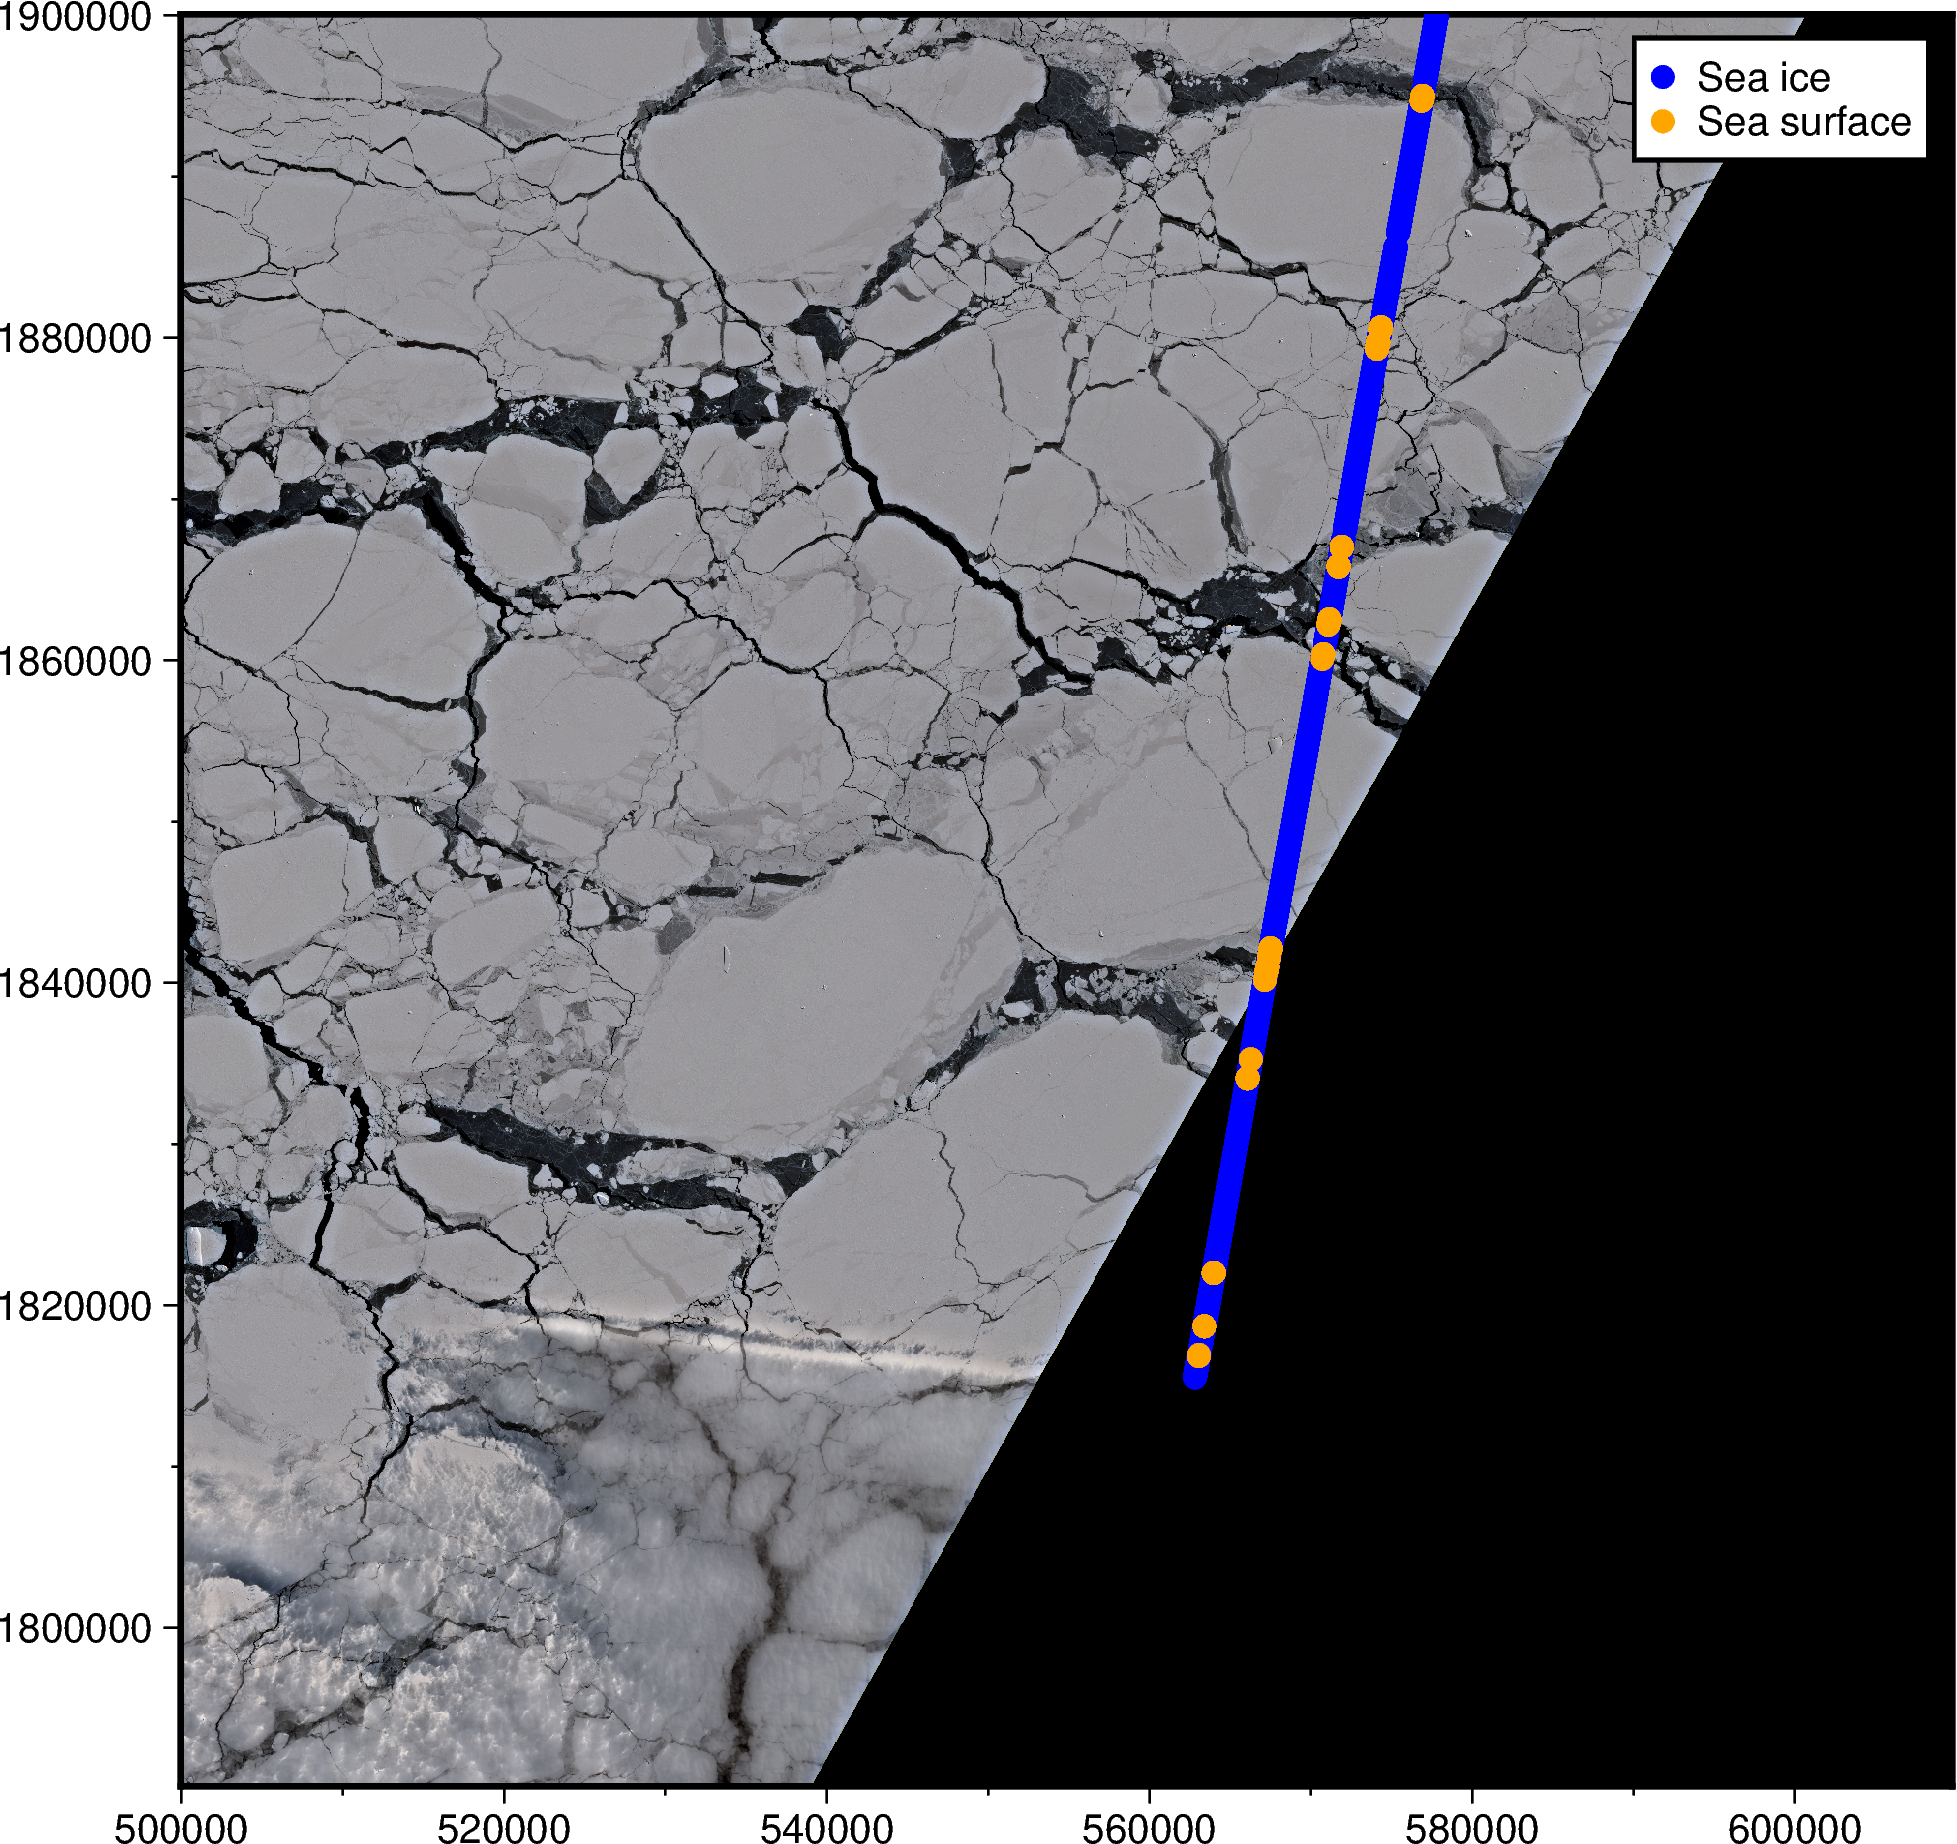

In [16]:
fig = pygmt.Figure()

# Plot Sentinel-2 RGB image
# Convert from 14-bit to 8-bit color scale for PyGMT
fig.grdimage(grid=((da_image / 2**14) * 2**8).astype(np.uint8), frame=True)

# Plot ATL07 points
# Sea ice points in blue
df_ice = gdf[gdf.height_segment_ssh_flag == 0].get_coordinates()
fig.plot(x=df_ice.x, y=df_ice.y, style="c0.2c", fill="blue", label="Sea ice")
# Sea surface points in orange
df_water = gdf[gdf.height_segment_ssh_flag == 1].get_coordinates()
fig.plot(x=df_water.x, y=df_water.y, style="c0.2c", fill="orange", label="Sea surface")
fig.legend()
fig.show()

Looking good! Notice how the orange (sea surface) coincide with the cracks in the sea
ice.

Next, we'll want to do better than a binary 0/1 or ice/water classification, and pick
up different shades of gray (white thick ice, gray thin ice, black water). Let's
use the X and Y coordinates from the point cloud to pick up surface reflectance values
from the Sentinel-2 image.

PyGMT's [`grdtrack`](https://www.pygmt.org/v0.12.0/api/generated/pygmt.grdtrack.html)
function can be used to do this X/Y sampling from a 1-band grid.

In [17]:
df_red = pygmt.grdtrack(
    grid=da_image.sel(band="red").compute(),  # Choose only the Red band
    points=gdf.get_coordinates(),  # x/y coordinates from ATL07
    newcolname="red_band_value",
    interpolation="n",  # nearest neighbour
)

grdtrack [WARNING]: Some input points were outside the grid domain(s).


<Axes: title={'center': 'Sentinel-2 red band values in y-direction'}, xlabel='y', ylabel='red_band_value'>

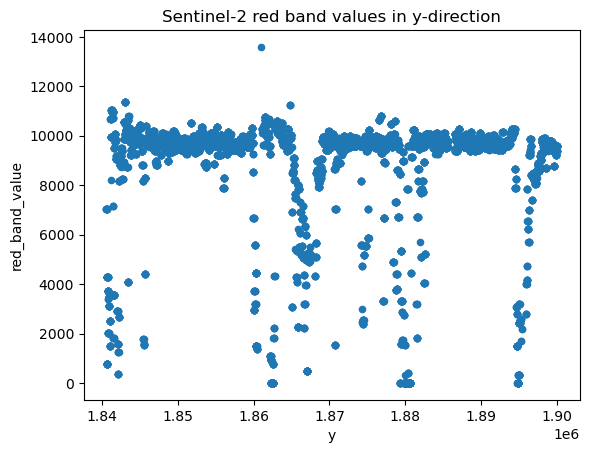

In [18]:
# Plot cross-section
df_red.plot.scatter(
    x="y", y="red_band_value", title="Sentinel-2 red band values in y-direction"
)

The cross-section view shows most points having a Red band reflectance value of 10000,
that should correspond to white sea ice. Darker values near 0 would be water, and
intermediate values around 6000 would be thin ice.

(Click 'Show code cell content' below if you'd like to see the histogram plot)

<Axes: title={'center': 'Sentinel-2 red band values'}, ylabel='Frequency'>

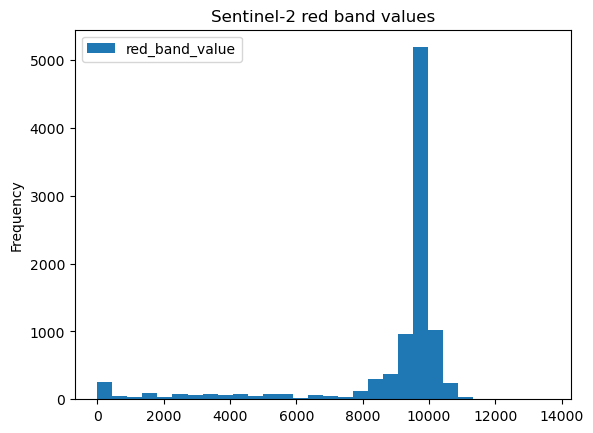

In [19]:
df_red.plot(
    kind="hist", column="red_band_value", bins=30, title="Sentinel-2 red band values"
)

To keep things simple, we'll label the `surface_type` of each ATL07 point
using a simple threshold:

| Int label |      Surface Type     |      Bin values     |
|-----------|:---------------------:|:-------------------:|
|     0     | Water (dark)          | `0 <= x <= 4000`    |
|     1     | Thin sea ice (gray)   | `4000 < x <= 8000`  |
|     2     | Thick sea ice (white) | `8000 < x <= 14000` |

In [20]:
gdf["surface_type"] = pd.cut(
    x=df_red["red_band_value"],
    bins=[0, 4000, 8000, 14000],
    labels=[0, 1, 2],  # "water", "thin_ice", "thick_ice"
)

There are some NaN values in some rows of our geodataframe (which had no matching
Sentinel-2 pixel value) that should be dropped here.

In [21]:
gdf = gdf.dropna().reset_index(drop=True)

In [22]:
gdf

index  photon_rate    hist_w  background_r_norm  height_segment_height  \
0      4388     8.647058  0.224312         5565264.00               0.605202   
1      4389     8.058824  0.173039         5587664.50               0.669868   
2      4390     7.941176  0.190458         5587664.50               0.736938   
3      4391     8.294118  0.250401         5587664.50               0.701096   
4      4392     7.882353  0.170319         5587670.50               0.620872   
...     ...          ...       ...                ...                    ...   
9449  13837     8.750000  0.148517         3209719.50              -0.032860   
9450  13838     9.866667  0.113973         3322385.75              -0.038391   
9451  13839    11.461538  0.130621         3322385.75              -0.046043   
9452  13840    12.083333  0.133239         3322386.75              -0.070625   
9453  13841    10.500000  0.136830         3322399.50              -0.038437   

      height_segment_n_pulse_seg  hist_mean_h  hist_median_h         x_atc  \
0                             16   -67.327896     -67.305969  2.821440e+07   
1                             16   -67.209755     -67.219963  2.821441e+07   
2                             16   -67.143631     -67.138664  2.821441e+07   
3                             16   -67.213936     -67.217377  2.821442e+07   
4                             16   -67.279953     -67.277100  2.821442e+07   
...                          ...          ...            ...           ...   
9449                          15   -68.235619     -68.211128  2.827476e+07   
9450                          14   -68.211784     -68.208221  2.827476e+07   
9451                          12   -68.220390     -68.207855  2.827477e+07   
9452                          11   -68.228592     -68.216240  2.827477e+07   
9453                          13   -68.216888     -68.200233  2.827478e+07   

      layer_flag  height_segment_ssh_flag                        geometry  \
0              0                        0  POINT (577809.769 1900049.731)   
1              0                        0  POINT (577808.777 1900044.162)   
2              0                        0  POINT (577807.757 1900038.423)   
3              0                        0  POINT (577806.783 1900032.932)   
4              0                        0  POINT (577805.803 1900027.401)   
...          ...                      ...                             ...   
9449           0                        0  POINT (567235.505 1840650.409)   
9450           0                        0  POINT (567234.707 1840645.805)   
9451           0                        1  POINT (567233.997 1840641.703)   
9452           0                        1  POINT (567233.382 1840638.147)   
9453           0                        0  POINT (567232.672 1840634.043)   

      hist_mean_median_h_diff surface_type  
0                   -0.021927            2  
1                    0.010208            2  
2                   -0.004967            2  
3                    0.003441            2  
4                   -0.002853            2  
...                       ...          ...  
9449                -0.024490            1  
9450                -0.003563            1  
9451                -0.012535            1  
9452                -0.012352            1  
9453                -0.016655            1  

[9454 rows x 14 columns]

### Save to GeoParquet

Let's save the ATL07 photon data to a GeoParquet file so we don't have to run all the
pre-processing code above again.

In [23]:
gdf.to_parquet(path="ATL07_photons.gpq", compression="zstd", schema_version="1.1.0")

```{note} To compress or not?
When storing your data, note that there is a tradeoff in terms of compression and read
speeds. Uncompressed data would typically be fastest to read (assuming no network
transfer) but result in large file sizes. We'll choose Zstandard (zstd) as the
compression method here as it provides a balance between fast reads (quicker than the
default 'snappy' compression codec), and good compression into a small file size.
```

In [24]:
# Load GeoParquet file back into geopandas.GeoDataFrame
gdf = gpd.read_parquet(path="ATL07_photons.gpq")

## Part 2: DataLoader and Model architecture

The following parts will bring us one step closer to having a full machine learning
pipeline. We will create:

1. A 'DataLoader', which is a fancy data container we can loop over; and
2. A neural network 'model' that will take our input ATL07 data and output photon
   classifications.

### From dataframe tables to batched tensors

Machine learning models are compute intensive, and typically run on specialized
hardware called Graphical Processing Units (GPUs) instead of ordinary CPUs. Depending
on your input data format (images, tables, audio, etc), and the machine learning
library/framework you'll use (e.g. Pytorch, Tensorflow, RAPIDS AI CuML, etc), there
will be different ways to transfer data from disk storage -> CPU -> GPU.

For this exercise, we'll be using [PyTorch](https://pytorch.org), and do the following
data conversions:

[`geopandas.GeoDataFrame`](https://geopandas.org/en/v1.0.0/docs/reference/api/geopandas.GeoDataFrame.html) ->
[`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/version/2.2/reference/api/pandas.DataFrame.html) ->
[`torch.Tensor`](https://pytorch.org/docs/2.4/tensors.html#torch.Tensor) ->
[torch `Dataset`](https://pytorch.org/docs/2.4/data.html#torch.utils.data.Dataset) ->
[torch `DataLoader`](https://pytorch.org/docs/2.4/data.html#torch.utils.data.DataLoader)

In [25]:
# Select data variables from DataFrame that will be used for training
df = gdf[
    [
        # Input variables
        "photon_rate",
        "hist_w",
        "background_r_norm",
        "height_segment_height",
        "height_segment_n_pulse_seg",
        "hist_mean_median_h_diff",
        # Output label (groundtruth)
        "surface_type",
    ]
]
tensor = torch.from_numpy(  # convert pandas.DataFrame to torch.Tensor (via numpy)
    df.to_numpy(dtype="float32")
)
# assert tensor.shape == torch.Size([9454, 7])  # (rows, columns)
dataset = torch.utils.data.TensorDataset(tensor)  # turn torch.Tensor into torch Dataset
dataloader = torch.utils.data.DataLoader(  # put torch Dataset in a DataLoader
    dataset=dataset,
    batch_size=128,  # mini-batch size
    shuffle=True,
)

This PyTorch
[`DataLoader`](https://pytorch.org/docs/2.4/data.html#torch.utils.data.DataLoader)
can be used in a for-loop to produce mini-batch tensors of shape (128, 7) later below.

### Choosing a Machine Learning algorithm

Next is to pick a supervised learning 'model' for our photon classification task.
There are a variety of machine learning methods to choose with different levels of
complexity:

- Easy - Decision trees (e.g. XGBoost, Random Forest), K-Nearest Neighbors, etc
- Medium - Basic neural networks (e.g. Multi-layer Perceptron, Convolutional neural
  networks, etc).
- Hard - State-of-the-art models (e.g. Graph Neural Networks, Transformers, State
  Space Models)

Let's take the middle ground and build a multi-layer perceptron, also known as an
artificial feedforward neural network.

```{seealso}
There are many frameworks catering to the different levels of Machine Learning models
mentioned above. Some notable ones are:

- Easy: 'Classic' ML - [Scikit-learn](https://scikit-learn.org) (CPU-based) and
  [CuML](https://docs.rapids.ai/api/cuml) (GPU-based)
- Medium: DIY Neural networks - [Pytorch](https://pytorch.org) and
  [Tensorflow](https://www.tensorflow.org)
- Hard: High-level ML frameworks - [Lightning](https://lightning.ai/docs/pytorch),
  [HuggingFace](https://huggingface.co/docs), etc.

While you might think that going from easy to hard is recommended, there are some
people who actually start with a (well-documented) framework and work their way down!
Do whatever works best for you on your machine learning journey.
```

A Pytorch model or
[`torch.nn.Module`](https://pytorch.org/docs/2.4/generated/torch.nn.Module.html) is
constructed as a Python class with an `__init__` method for the neural network layers,
and a `forward` method for the forward pass (how the data passes through the layers).

This multi-layer perceptron below will have:
- An input layer with 6 nodes, corresponding to the 6 input data variables
- Two hidden layers, 50 nodes each
- Output layer with 3 nodes, for 3 surface types (open water, thin ice,
  thick/snow-covered ice)

In [26]:
class PhotonClassificationModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_features=6, out_features=50)
        self.linear2 = torch.nn.Linear(in_features=50, out_features=50)
        self.linear3 = torch.nn.Linear(in_features=50, out_features=3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.linear1(x)
        x2 = self.linear2(x1)
        x3 = self.linear3(x2)
        return x3

In [27]:
model = PhotonClassificationModel()
# model = model.to(device="cuda") # uncomment this line if running on GPU
model

PhotonClassificationModel(
  (linear1): Linear(in_features=6, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=3, bias=True)
)

## Part 3: Training the neural network

Now is the time to train the ML model! We'll need to:
1. Choose a [loss function](https://pytorch.org/docs/2.4/nn.html#loss-functions) and
   [optimizer](https://pytorch.org/docs/2.4/optim.html)
2. Configure training hyperparameters such as the learning rate (`lr`) and number of
   epochs (`max_epochs`) or iterations over the entire training dataset.
3. Construct the main training loop to:
   - get a mini-batch from the DataLoader
   - pass the mini-batch data into the model to get a prediction
   - minimize the error (or loss) between the prediction and groundtruth

Let's see how this is done!

In [ ]:
# Setup loss function and optimizer
loss_bce = torch.nn.BCEWithLogitsLoss()  # binary cross entropy loss
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
# Main training loop
max_epochs: int = 3
size = len(dataloader.dataset)
for epoch in tqdm.tqdm(iterable=range(max_epochs)):
    for i, batch in enumerate(dataloader):
        minibatch: torch.Tensor = batch[0]
        # assert minibatch.shape == (128, 7)
        assert minibatch.device == torch.device("cpu")  # Data is on CPU

        # Uncomment two lines below if GPU is available
        # minibatch = minibatch.to(device="cuda")  # Move data to GPU
        # assert minibatch.device == torch.device("cuda:0")  # Data is on GPU now!

        # Split data into input (x) and target (y)
        x = minibatch[:, :6]  # Input is in first 6 columns
        y = minibatch[:, 6]  # Output (groundtruth) is in 7th column
        y_target = torch.nn.functional.one_hot(y.to(dtype=torch.int64), 3)  # 3 classes

        # Pass data into neural network model
        prediction = model(x=x)

        # Compute prediction error
        loss = loss_bce(input=prediction, target=y_target.to(dtype=torch.float32))

        # Backpropagation (to minimize loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Report metrics
        current = (i + 1) * len(x)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Did the model learn something? A good sign to check is if the loss value is
decreasing, which means the error between the predicted and groundtruth value is
getting smaller.

## References
- Koo, Y., Xie, H., Kurtz, N. T., Ackley, S. F., & Wang, W. (2023).
  Sea ice surface type classification of ICESat-2 ATL07 data by using data-driven
  machine learning model: Ross Sea, Antarctic as an example. Remote Sensing of
  Environment, 296, 113726. https://doi.org/10.1016/j.rse.2023.113726